In [101]:
import os
import pandas as pd
import numpy as np

import datetime as dt
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier,SGDClassifier
from sklearn.metrics import confusion_matrix,r2_score, roc_auc_score,accuracy_score



pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 500)

### Functions

In [2]:
# nv = []
# for t in tabs:
#     for c in t:
#         if len(t[c].unique()) < 100:
#             nv.append(len(t[c].unique()))

In [3]:
def plot_hist(df,col,bins = 5):
    
    aux = df.copy()
    if len(aux[col].unique()) <= 28:
        frec = df[col].value_counts()
        frec.plot(kind='bar')
    else:
        plt.hist(aux[col], bins=bins)
        
        
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia")
    plt.title(col)

    plt.show()

def outliers_perc(df,col,p_i = 1,p_f=99):
    aux = df.copy()
    ci = np.percentile(aux[col],p_i)
    cs = np.percentile(aux[col],p_f)
    aux = aux[( ci<= aux[col]) & (aux[col] <= cs)]
    print(f'Se conserva el: {"{:.2f}".format(aux[col].count()/df[col].count())}')
    
    return aux


### LOAD

In [4]:
path = '/home/mike/Documentos/GitHub/Coppel/data/'
files = [x for x in os.listdir(path) if x[-4:] == '.csv']
l2 = ['cus_dem','camp','cus_tran','tst','trn','item','coup_itmap']
dic = dict(zip(files,l2))

tabs = []
for f in files:
#     print(f)
    exec(f'{dic[f]} = pd.read_csv(path + f)')
    exec(f'tabs.append({dic[f]})')
cus_tran.date = cus_tran['date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))
camp.start_date = camp.start_date.apply(lambda x: dt.datetime.strptime(x,'%d/%m/%y'))
camp.end_date = camp.end_date.apply(lambda x: dt.datetime.strptime(x,'%d/%m/%y'))

### Análisis Univariado

age_range


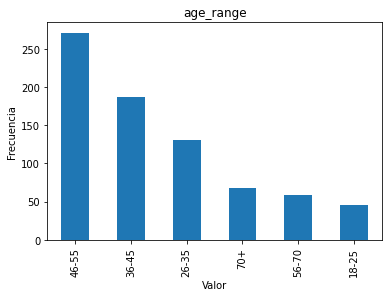

marital_status


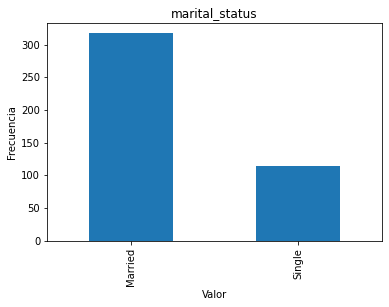

rented


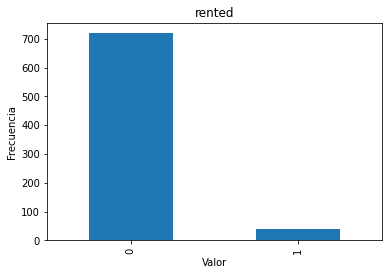

family_size


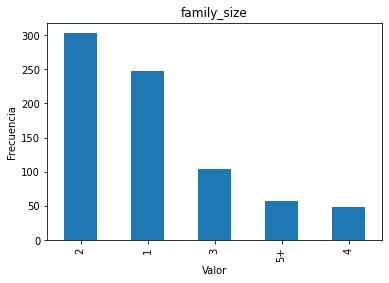

no_of_children


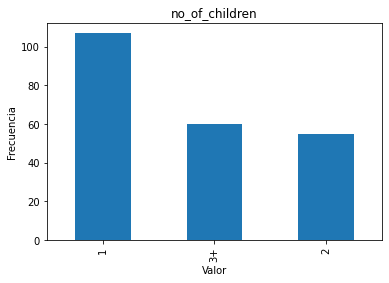

income_bracket


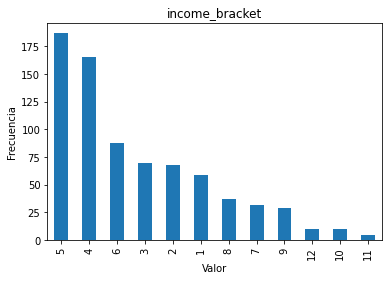

campaign_type


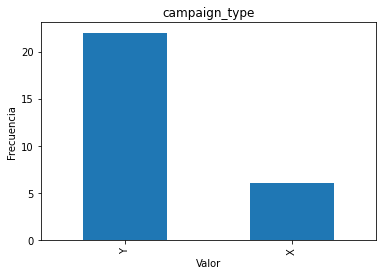

start_date


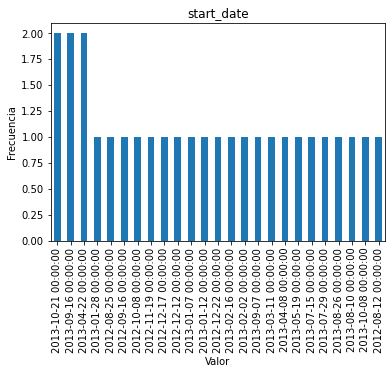

end_date


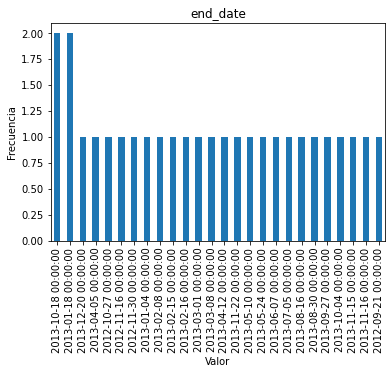

date


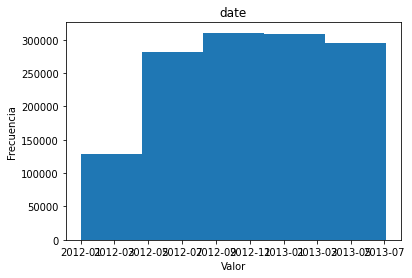

quantity


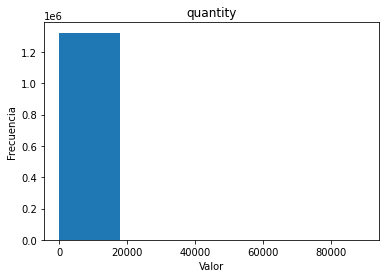

selling_price


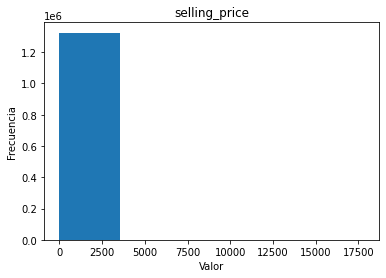

other_discount


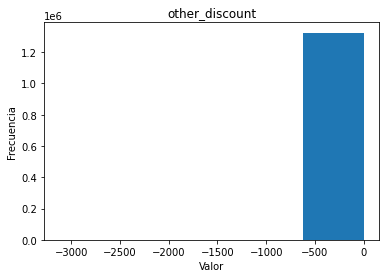

coupon_discount


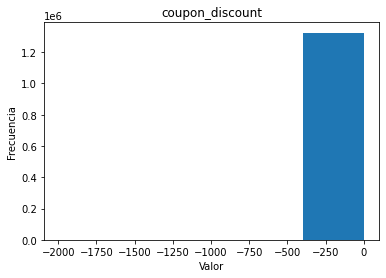

redemption_status


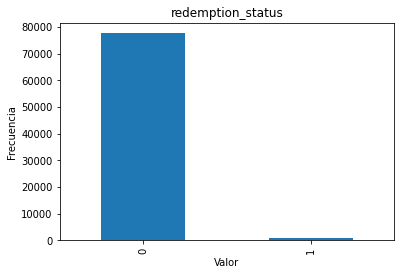

brand


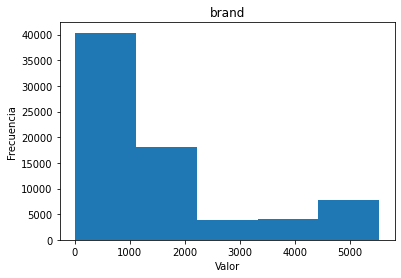

brand_type


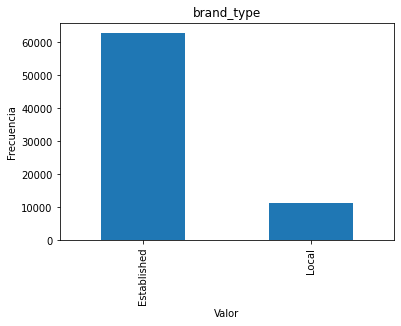

category


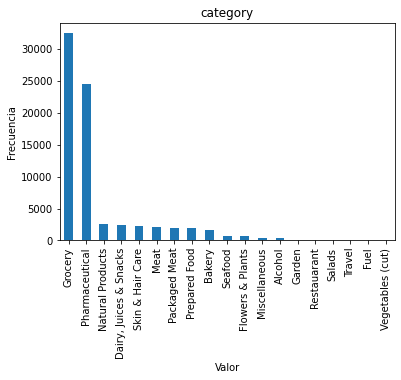

In [5]:

elems = []
for t in tabs:
#     print(t)
    for c in t.columns:
        if '_id' not in c and 'id_' not in c  and 'id' not in c:
            print(c)
            plot_hist(t,c)
            elems.append(c)

In [6]:
cus_tran.date.value_counts()

2012-09-03    4753
2012-10-03    4703
2012-11-15    4372
2012-09-13    4024
2012-10-11    3957
              ... 
2012-01-07     197
2012-01-02     177
2012-01-06     122
2012-01-03      65
2012-10-05       6
Name: date, Length: 549, dtype: int64

In [7]:
# aux = pd.DataFrame(list(zip(sorted(cus_tran.date.unique().tolist()),sorted(cus_tran.date.unique().tolist()[1:]))),columns=['N','N1'])
# aux.N = aux.N.astype('datetime64')
# aux.N1 = aux.N1.astype('datetime64')
# aux['diff'] = aux.N1 - aux.N
# set(aux['diff'])

### Tratamiento Outliers

In [8]:
ls = [x for x in cus_tran.columns if 'id' not in x and 'date' not in x]
bef = cus_tran.shape[0]
for v in ls:
    print(v)
    cus_tran = outliers_perc(cus_tran,v)
aft = cus_tran.shape[0]
print(f'\n Finalmente, se conserva el: {"{:.2f}".format(aft/bef)}')


quantity
Se conserva el: 0.99
selling_price
Se conserva el: 0.98
other_discount
Se conserva el: 0.99
coupon_discount
Se conserva el: 0.99

 Finalmente, se conserva el: 0.95


### Parámetros

In [9]:
camp_trn = camp[(camp.campaign_id.isin(trn.campaign_id.unique())) & (camp.start_date <= '2013-07-01')]['campaign_id'].unique().tolist()
camp_tst = camp[(camp.campaign_id.isin(trn.campaign_id.unique())) & (camp.start_date > '2013-07-01')]['campaign_id'].unique().tolist()

In [10]:
cus_tran['redemption_status'] = (cus_tran.coupon_discount != 0)*1

In [11]:
psumm = pd.merge(cus_tran,pd.merge(pd.merge(trn,coup_itmap,how='left',on='coupon_id'),camp,how='left',on='campaign_id'),how='left',on=['customer_id','item_id','redemption_status'])
psumm

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,redemption_status,id,campaign_id,coupon_id,campaign_type,start_date,end_date
0,2012-01-02,1501,26830,1,35.26,-10.69,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT
1,2012-01-02,1501,54253,1,53.43,-13.89,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT
2,2012-01-02,1501,31962,1,106.50,-14.25,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT
3,2012-01-02,1501,33647,1,67.32,0.00,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT
4,2012-01-02,1501,48199,1,71.24,-28.14,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270626,2013-06-30,1129,2777,1,284.60,-71.24,0.00,0,75918.00,8.00,1084.00,X,2013-02-16,2013-04-05
1270627,2013-06-30,1129,2953,4,42.74,-28.50,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT
1270628,2013-06-30,1129,2971,6,64.12,-42.74,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT
1270629,2013-06-30,1129,46984,1,95.82,0.00,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT


In [43]:
probcup = psumm[psumm.redemption_status == 1]['coupon_id'].value_counts(True).reset_index()
probcup.columns = ['coupon_id','proba_cupon']
probcup

,coupon_id,proba_cupon
0,21.00,0.14
1,9.00,0.06
2,586.00,0.06
3,22.00,0.05
4,6.00,0.05
...,...,...
79,1020.00,0.00
80,407.00,0.00
81,667.00,0.00
82,692.00,0.00


In [13]:
probcamt = psumm[(~psumm.campaign_type.isna()) & (psumm.redemption_status == 1)]['campaign_type'].copy()
probcamt = pd.DataFrame(probcamt.value_counts(True).reset_index())
probcamt.columns = ['campaign_type','proba_camptype']
probcamt

,campaign_type,proba_camptype
0,X,0.91
1,Y,0.09


In [14]:
probstmt = psumm[(~psumm.start_date.isna()) & (psumm.redemption_status == 1)]['start_date'].dt.month.copy()
probstmt = pd.DataFrame(probstmt.value_counts(True).reset_index())
probstmt.columns = ['start_month','proba_month']
probstmt

,start_month,proba_month
0,5,0.58
1,2,0.27
2,4,0.05
3,11,0.03
4,8,0.02
5,1,0.01
6,12,0.01
7,10,0.01
8,9,0.00


In [15]:
probstwd = psumm[(~psumm.start_date.isna()) & (psumm.redemption_status == 1)]['start_date'].dt.weekday.copy()
probstwd = pd.DataFrame(probstwd.value_counts(True).reset_index())
probstwd.columns = ['start_weekday','proba_wd']
probstwd

,start_weekday,proba_wd
0,6,0.61
1,5,0.27
2,0,0.12


In [16]:
psumm2 = pd.merge(psumm,cus_dem,how='left',on='customer_id')
psumm2

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,redemption_status,id,campaign_id,coupon_id,campaign_type,start_date,end_date,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,2012-01-02,1501,26830,1,35.26,-10.69,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-02,1501,54253,1,53.43,-13.89,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-01-02,1501,31962,1,106.50,-14.25,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-01-02,1501,33647,1,67.32,0.00,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-01-02,1501,48199,1,71.24,-28.14,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270626,2013-06-30,1129,2777,1,284.60,-71.24,0.00,0,75918.00,8.00,1084.00,X,2013-02-16,2013-04-05,70+,NaN,0.00,2,NaN,9.00
1270627,2013-06-30,1129,2953,4,42.74,-28.50,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT,70+,NaN,0.00,2,NaN,9.00
1270628,2013-06-30,1129,2971,6,64.12,-42.74,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT,70+,NaN,0.00,2,NaN,9.00
1270629,2013-06-30,1129,46984,1,95.82,0.00,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT,70+,NaN,0.00,2,NaN,9.00


In [17]:
probage = psumm2[(~psumm2.age_range.isna()) & (psumm2.redemption_status == 1)]['age_range'].copy()
probage = pd.DataFrame(probage.value_counts(True).reset_index())
probage.columns = ['age_range','proba_rage']
probage

,age_range,proba_rage
0,46-55,0.36
1,36-45,0.30
2,26-35,0.15
3,56-70,0.11
4,70+,0.05
5,18-25,0.04


In [18]:
probmars = psumm2[(~psumm2.marital_status.isna()) & (psumm2.redemption_status == 1)]['marital_status'].copy()
probmars = pd.DataFrame(probmars.value_counts(True).reset_index())
probmars.columns = ['marital_status','proba_marst']
probmars

,marital_status,proba_marst
0,Married,0.81
1,Single,0.19


In [19]:
probinbra = psumm2[(~psumm2.income_bracket.isna()) & (psumm2.redemption_status == 1)]['income_bracket'].copy()
probinbra = pd.DataFrame(probinbra.value_counts(True).reset_index())
probinbra.columns = ['income_bracket','proba_inbra']
probinbra

,income_bracket,proba_inbra
0,5.00,0.33
1,6.00,0.17
2,4.00,0.16
3,3.00,0.08
4,8.00,0.07
5,1.00,0.06
6,9.00,0.06
7,2.00,0.05
8,7.00,0.03
9,11.00,0.01


In [20]:
cus_tran['trns_date'] = cus_tran.date.apply(lambda x: x.replace(day = 1))
cus_tran

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,redemption_status,trns_date
0,2012-01-02,1501,26830,1,35.26,-10.69,0.00,0,2012-01-01
1,2012-01-02,1501,54253,1,53.43,-13.89,0.00,0,2012-01-01
2,2012-01-02,1501,31962,1,106.50,-14.25,0.00,0,2012-01-01
3,2012-01-02,1501,33647,1,67.32,0.00,0.00,0,2012-01-01
4,2012-01-02,1501,48199,1,71.24,-28.14,0.00,0,2012-01-01
...,...,...,...,...,...,...,...,...,...
1324561,2013-06-30,1129,2777,1,284.60,-71.24,0.00,0,2013-06-01
1324562,2013-06-30,1129,2953,4,42.74,-28.50,0.00,0,2013-06-01
1324563,2013-06-30,1129,2971,6,64.12,-42.74,0.00,0,2013-06-01
1324564,2013-06-30,1129,46984,1,95.82,0.00,0.00,0,2013-06-01


In [21]:
%%time

cus_hist = pd.DataFrame()
for c in list(cus_tran.customer_id.unique()):
    aux = pd.DataFrame(cus_tran[cus_tran.customer_id == c][['customer_id','trns_date','selling_price','coupon_discount']].groupby(['customer_id','trns_date']).sum().copy().to_records())
    if aux.shape[0]-10 >= 0: 
        for n in range(aux.shape[0]-10+1):
            aux2 = aux.shift(n).tail(10).copy()
            aux2['desplazo'] = n
            aux2 = aux2.reset_index(drop=True).reset_index().rename(columns={'index':'tiempo'})
            aux2['tiempo'] = aux2['tiempo']-9
            aux2['ini'] = aux2.trns_date.min()
            aux2['fin'] = aux2.trns_date.max()
            aux2 = aux2.drop(columns='trns_date')
            cus_hist = pd.concat([cus_hist,aux2])
            
cus_hist = pd.DataFrame(pd.pivot_table(cus_hist,index=['customer_id','ini','fin','desplazo'],columns=['tiempo'],values=['selling_price','coupon_discount']).to_records())
cus_hist.columns = [x.replace("('","").replace("', ","_").replace(")","") for x in cus_hist.columns]
cus_hist = pd.merge(cus_hist,cus_tran[cus_tran.redemption_status == 1][['customer_id','trns_date','redemption_status']],how='left',left_on=['customer_id','fin'],right_on=['customer_id','trns_date'])
cus_hist.redemption_status = cus_hist.redemption_status.fillna(0)
cus_hist = cus_hist.drop(columns='trns_date')
cus_hist

CPU times: user 36 s, sys: 0 ns, total: 36 s
Wall time: 36 s


,customer_id,ini,fin,desplazo,coupon_discount_-9,coupon_discount_-8,coupon_discount_-7,coupon_discount_-6,coupon_discount_-5,coupon_discount_-4,coupon_discount_-3,coupon_discount_-2,coupon_discount_-1,coupon_discount_0,selling_price_-9,selling_price_-8,selling_price_-7,selling_price_-6,selling_price_-5,selling_price_-4,selling_price_-3,selling_price_-2,selling_price_-1,selling_price_0,redemption_status
0,1.00,2012-02-01,2012-11-01,7,0.00,0.00,-17.81,-53.42,-26.71,-14.25,-64.12,0.00,-105.08,-12.47,2425.71,1944.83,4980.02,7936.80,7024.57,4701.12,5177.69,4353.79,7465.57,3906.41,1.00
1,1.00,2012-03-01,2012-12-01,6,0.00,-17.81,-53.42,-26.71,-14.25,-64.12,0.00,-105.08,-12.47,-12.47,1944.83,4980.02,7936.80,7024.57,4701.12,5177.69,4353.79,7465.57,3906.41,7912.53,1.00
2,1.00,2012-04-01,2013-01-01,5,-17.81,-53.42,-26.71,-14.25,-64.12,0.00,-105.08,-12.47,-12.47,-17.81,4980.02,7936.80,7024.57,4701.12,5177.69,4353.79,7465.57,3906.41,7912.53,2091.23,1.00
3,1.00,2012-05-01,2013-02-01,4,-53.42,-26.71,-14.25,-64.12,0.00,-105.08,-12.47,-12.47,-17.81,-115.77,7936.80,7024.57,4701.12,5177.69,4353.79,7465.57,3906.41,7912.53,2091.23,7608.37,1.00
4,1.00,2012-05-01,2013-02-01,4,-53.42,-26.71,-14.25,-64.12,0.00,-105.08,-12.47,-12.47,-17.81,-115.77,7936.80,7024.57,4701.12,5177.69,4353.79,7465.57,3906.41,7912.53,2091.23,7608.37,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12331,1582.00,2012-06-01,2013-03-01,3,0.00,0.00,0.00,0.00,0.00,-190.57,-17.81,0.00,-24.94,0.00,1974.78,3253.14,3799.21,4234.83,3639.29,5635.42,5599.07,7562.12,7348.73,6652.36,0.00
12332,1582.00,2012-07-01,2013-04-01,2,0.00,0.00,0.00,0.00,-190.57,-17.81,0.00,-24.94,0.00,0.00,3253.14,3799.21,4234.83,3639.29,5635.42,5599.07,7562.12,7348.73,6652.36,4780.93,0.00
12333,1582.00,2012-08-01,2013-05-01,1,0.00,0.00,0.00,-190.57,-17.81,0.00,-24.94,0.00,0.00,0.00,3799.21,4234.83,3639.29,5635.42,5599.07,7562.12,7348.73,6652.36,4780.93,6709.03,0.00
12334,1582.00,2012-09-01,2013-06-01,0,0.00,0.00,-190.57,-17.81,0.00,-24.94,0.00,0.00,0.00,-24.94,4234.83,3639.29,5635.42,5599.07,7562.12,7348.73,6652.36,4780.93,6709.03,4967.54,1.00


In [23]:
cus_hist.redemption_status.value_counts(True)

0.00   0.76
1.00   0.24
Name: redemption_status, dtype: float64

In [24]:
psumm2['trns_date'] = psumm2.date.apply(lambda x: x.replace(day = 1))
psumm2['fin'] = psumm2.trns_date.apply(lambda x: x - relativedelta(months=1))
psumm2

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,redemption_status,id,campaign_id,coupon_id,campaign_type,start_date,end_date,age_range,marital_status,rented,family_size,no_of_children,income_bracket,trns_date,fin
0,2012-01-02,1501,26830,1,35.26,-10.69,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,2012-01-01,2011-12-01
1,2012-01-02,1501,54253,1,53.43,-13.89,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,2012-01-01,2011-12-01
2,2012-01-02,1501,31962,1,106.50,-14.25,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,2012-01-01,2011-12-01
3,2012-01-02,1501,33647,1,67.32,0.00,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,2012-01-01,2011-12-01
4,2012-01-02,1501,48199,1,71.24,-28.14,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,2012-01-01,2011-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270626,2013-06-30,1129,2777,1,284.60,-71.24,0.00,0,75918.00,8.00,1084.00,X,2013-02-16,2013-04-05,70+,NaN,0.00,2,NaN,9.00,2013-06-01,2013-05-01
1270627,2013-06-30,1129,2953,4,42.74,-28.50,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT,70+,NaN,0.00,2,NaN,9.00,2013-06-01,2013-05-01
1270628,2013-06-30,1129,2971,6,64.12,-42.74,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT,70+,NaN,0.00,2,NaN,9.00,2013-06-01,2013-05-01
1270629,2013-06-30,1129,46984,1,95.82,0.00,0.00,0,NaN,NaN,NaN,NaN,NaT,NaT,70+,NaN,0.00,2,NaN,9.00,2013-06-01,2013-05-01


In [64]:
predata = pd.merge(psumm2,cus_hist,how='left',on=['customer_id','fin','redemption_status'])
predata = predata[~predata.desplazo.isna()][['redemption_status','customer_id','coupon_id','campaign_type','start_date','end_date','age_range','marital_status','income_bracket'] + cus_hist.columns[1:-1].tolist()]
predata = pd.merge(predata,probcup, how='left',on='coupon_id')
predata = pd.merge(predata,probcamt, how='left',on='campaign_type')
predata['start_month'] = predata.start_date.dt.month
predata = pd.merge(predata,probstmt, how='left',on='start_month')
predata['start_weekday'] = predata.start_date.dt.weekday
predata = pd.merge(predata,probstwd, how='left',on='start_weekday')
predata = pd.merge(predata,probage, how='left',on='age_range')
predata = pd.merge(predata,probmars, how='left',on='marital_status')
predata = pd.merge(predata,probinbra, how='left',on='income_bracket')
predata = predata.fillna(0)

In [70]:
features = ['coupon_discount_-9', 'coupon_discount_-8', 'coupon_discount_-7',
           'coupon_discount_-6', 'coupon_discount_-5', 'coupon_discount_-4',
           'coupon_discount_-3', 'coupon_discount_-2', 'coupon_discount_-1',
           'coupon_discount_0', 'selling_price_-9', 'selling_price_-8',
           'selling_price_-7', 'selling_price_-6', 'selling_price_-5',
           'selling_price_-4', 'selling_price_-3', 'selling_price_-2',
           'selling_price_-1', 'selling_price_0', 'proba_cupon', 'proba_camptype',
            'proba_month', 'proba_wd', 'proba_rage','proba_marst', 'proba_inbra']
tgt = ['redemption_status']

In [71]:
predata[features+tgt]

,coupon_discount_-9,coupon_discount_-8,coupon_discount_-7,coupon_discount_-6,coupon_discount_-5,coupon_discount_-4,coupon_discount_-3,coupon_discount_-2,coupon_discount_-1,coupon_discount_0,selling_price_-9,selling_price_-8,selling_price_-7,selling_price_-6,selling_price_-5,selling_price_-4,selling_price_-3,selling_price_-2,selling_price_-1,selling_price_0,proba_cupon,proba_camptype,proba_month,proba_wd,proba_rage,proba_marst,proba_inbra,redemption_status
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,66.97,301.34,220.13,883.01,4727.83,11651.98,5506.80,15093.26,12163.15,14261.53,0.00,0.91,0.58,0.61,0.00,0.00,0.00,0
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,66.97,301.34,220.13,883.01,4727.83,11651.98,5506.80,15093.26,12163.15,14261.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,66.97,301.34,220.13,883.01,4727.83,11651.98,5506.80,15093.26,12163.15,14261.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,66.97,301.34,220.13,883.01,4727.83,11651.98,5506.80,15093.26,12163.15,14261.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,66.97,301.34,220.13,883.01,4727.83,11651.98,5506.80,15093.26,12163.15,14261.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393108,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16284.31,15294.05,8826.23,6482.80,3485.05,6622.79,5318.39,8450.43,835.99,6314.31,0.00,0.91,0.27,0.27,0.05,0.00,0.06,0
393109,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16284.31,15294.05,8826.23,6482.80,3485.05,6622.79,5318.39,8450.43,835.99,6314.31,0.00,0.00,0.00,0.00,0.05,0.00,0.06,0
393110,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16284.31,15294.05,8826.23,6482.80,3485.05,6622.79,5318.39,8450.43,835.99,6314.31,0.00,0.00,0.00,0.00,0.05,0.00,0.06,0
393111,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16284.31,15294.05,8826.23,6482.80,3485.05,6622.79,5318.39,8450.43,835.99,6314.31,0.00,0.00,0.00,0.00,0.05,0.00,0.06,0


In [72]:
predata.redemption_status.value_counts(True)

0   0.98
1   0.02
Name: redemption_status, dtype: float64

### Oversampling

In [83]:
ros = RandomOverSampler(sampling_strategy=0.3)
X,Y = ros.fit_resample(predata[features],predata[tgt])
data = pd.concat([X,Y],axis=1)

### Modelado

In [88]:
train,test=train_test_split(data,test_size=0.30)
scores=[]

In [96]:
train[features+tgt].corr()

,coupon_discount_-9,coupon_discount_-8,coupon_discount_-7,coupon_discount_-6,coupon_discount_-5,coupon_discount_-4,coupon_discount_-3,coupon_discount_-2,coupon_discount_-1,coupon_discount_0,selling_price_-9,selling_price_-8,selling_price_-7,selling_price_-6,selling_price_-5,selling_price_-4,selling_price_-3,selling_price_-2,selling_price_-1,selling_price_0,proba_cupon,proba_camptype,proba_month,proba_wd,proba_rage,proba_marst,proba_inbra,redemption_status
coupon_discount_-9,1.00,0.57,0.42,0.76,0.74,0.38,0.32,0.54,0.56,0.81,-0.23,-0.28,-0.29,-0.22,-0.16,-0.18,-0.27,-0.27,-0.31,-0.30,-0.06,-0.10,-0.11,-0.11,-0.21,-0.31,-0.33,-0.51
coupon_discount_-8,0.57,1.00,0.55,0.41,0.71,0.70,0.34,0.44,0.55,0.43,-0.16,-0.23,-0.24,-0.23,-0.17,-0.14,-0.17,-0.23,-0.21,-0.25,-0.08,-0.13,-0.14,-0.14,-0.21,-0.29,-0.26,-0.54
coupon_discount_-7,0.42,0.55,1.00,0.45,0.46,0.58,0.58,0.48,0.48,0.43,-0.17,-0.16,-0.21,-0.17,-0.14,-0.14,-0.16,-0.15,-0.16,-0.16,-0.03,-0.06,-0.05,-0.06,-0.22,-0.30,-0.22,-0.57
coupon_discount_-6,0.76,0.41,0.45,1.00,0.63,0.31,0.42,0.63,0.58,0.80,-0.19,-0.27,-0.23,-0.20,-0.14,-0.18,-0.27,-0.23,-0.26,-0.23,-0.02,-0.04,-0.04,-0.04,-0.23,-0.32,-0.30,-0.54
coupon_discount_-5,0.74,0.71,0.46,0.63,1.00,0.55,0.40,0.57,0.70,0.68,-0.15,-0.23,-0.27,-0.20,-0.17,-0.14,-0.24,-0.27,-0.28,-0.27,-0.06,-0.11,-0.12,-0.12,-0.23,-0.35,-0.35,-0.58
coupon_discount_-4,0.38,0.70,0.58,0.31,0.55,1.00,0.45,0.50,0.51,0.37,-0.13,-0.13,-0.16,-0.19,-0.12,-0.18,-0.13,-0.18,-0.19,-0.25,-0.03,-0.08,-0.08,-0.08,-0.23,-0.28,-0.25,-0.57
coupon_discount_-3,0.32,0.34,0.58,0.42,0.40,0.45,1.00,0.55,0.53,0.40,-0.11,-0.11,-0.11,-0.09,-0.12,-0.08,-0.18,-0.11,-0.14,-0.16,0.01,-0.02,-0.00,-0.00,-0.19,-0.25,-0.20,-0.59
coupon_discount_-2,0.54,0.44,0.48,0.63,0.57,0.50,0.55,1.00,0.65,0.62,-0.16,-0.18,-0.16,-0.16,-0.10,-0.15,-0.19,-0.21,-0.21,-0.23,-0.03,-0.06,-0.05,-0.04,-0.24,-0.27,-0.26,-0.64
coupon_discount_-1,0.56,0.55,0.48,0.58,0.70,0.51,0.53,0.65,1.00,0.62,-0.16,-0.21,-0.21,-0.16,-0.16,-0.13,-0.22,-0.20,-0.26,-0.24,-0.03,-0.07,-0.07,-0.07,-0.25,-0.28,-0.30,-0.65
coupon_discount_0,0.81,0.43,0.43,0.80,0.68,0.37,0.40,0.62,0.62,1.00,-0.22,-0.27,-0.24,-0.16,-0.11,-0.16,-0.27,-0.25,-0.27,-0.30,-0.04,-0.05,-0.06,-0.05,-0.23,-0.29,-0.31,-0.67


/home/mike/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mike/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mike/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for e

### Regresión Logistica

In [91]:
logreg = LogisticRegression()
logreg.fit(train[features],train[tgt])
ls_res = cross_val_score(estimator = logreg, X=train[features], y=train[tgt], cv=5, n_jobs=-1, scoring='roc_auc')
scores.append({'Modelo':'logreg','Mean':ls_res.mean(),'Std':ls_res.std()})
print(f'Mean:{ls_res.mean()}')
print(f'std:{ls_res.std()}')

/home/mike/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mike/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mean:0.9976416505991159
std:0.0008862904763329663


### Regresión Ridge

In [94]:
ridreg=RidgeClassifier()
ridreg.fit(train[features],train[tgt])
ls_res = cross_val_score(estimator = ridreg, X=train[features], y=train[tgt], cv=5, n_jobs=-1, scoring='roc_auc')
scores.append({'Modelo':'ridreg','Mean':ls_res.mean(),'Std':ls_res.std()})
print(f'Mean:{ls_res.mean()}')
print(f'std:{ls_res.std()}')

/home/mike/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1178: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean:0.9838602216237632
std:0.00029409667697717634


### Gradiente Estocastico Decendiente

In [98]:
sgdc=SGDClassifier()
sgdc.fit(train[features],train[tgt])
ls_res = cross_val_score(estimator = sgdc, X=train[features], y=train[tgt], cv=5, n_jobs=-1, scoring='roc_auc')
scores.append({'Modelo':'sgdc','Mean':ls_res.mean(),'Std':ls_res.std()})
print(f'Mean:{ls_res.mean()}')
print(f'std:{ls_res.std()}')

/home/mike/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean:0.9897163332793136
std:0.007121720777845878


### KNN

In [102]:
knn = KNeighborsClassifier()
knn.fit(train[features],train[tgt])
ls_res = cross_val_score(estimator = knn, X=train[features], y=train[tgt], cv=5, n_jobs=-1, scoring='roc_auc')
scores.append({'Modelo':'knn','Mean':ls_res.mean(),'Std':ls_res.std()})
print(f'Mean:{ls_res.mean()}')
print(f'std:{ls_res.std()}')

/home/mike/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Mean:0.9999907364633189
std:5.809925617952138e-06


### Arboles de Decisión

In [103]:
arb = DecisionTreeClassifier()
arb.fit(train[features],train[tgt])
ls_res = cross_val_score(estimator = arb, X=train[features], y=train[tgt], cv=5, n_jobs=-1, scoring='roc_auc')
scores.append({'Modelo':'arb','Mean':ls_res.mean(),'Std':ls_res.std()})
print(f'Mean:{ls_res.mean()}')
print(f'std:{ls_res.std()}')

Mean:1.0
std:0.0


### Bosques Aleatorios

In [106]:
bos = RandomForestClassifier()
bos.fit(train[features],train[tgt])
ls_res = cross_val_score(estimator = bos, X=train[features], y=train[tgt], cv=5, n_jobs=-1, scoring='roc_auc')
scores.append({'Modelo':'bos','Mean':ls_res.mean(),'Std':ls_res.std()})
print(f'Mean:{ls_res.mean()}')
print(f'std:{ls_res.std()}')

/tmp/ipykernel_98640/398324516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  bos.fit(train[features],train[tgt])


Mean:1.0
std:0.0


## AdaBoost

In [107]:
ada = AdaBoostClassifier()
ada.fit(train[features],train[tgt])
ls_res = cross_val_score(estimator = ada, X=train[features], y=train[tgt], cv=5, n_jobs=-1, scoring='roc_auc')
scores.append({'Modelo':'ada','Mean':ls_res.mean(),'Std':ls_res.std()})
print(f'Mean:{ls_res.mean()}')
print(f'std:{ls_res.std()}')

/home/mike/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean:1.0
std:0.0


In [109]:
scores=pd.DataFrame(scores)

In [111]:
scores.sort_values(by='Mean',ascending=False)

,Modelo,Mean,Std
4,arb,1.00,0.00
6,bos,1.00,0.00
7,ada,1.00,0.00
5,mlp,1.00,0.00
3,knn,1.00,0.00
0,logreg,1.00,0.00
2,sgdc,0.99,0.01
1,ridreg,0.98,0.00


### Test

In [112]:
test['y_hat'] = logreg.predict(test[features])

In [113]:
accuracy_score(test[tgt],test['y_hat'])

0.9952295766249255

In [114]:
confusion_matrix(test[tgt],test['y_hat'])

array([[115674,    401],
       [   319,  34536]])

### Validate

In [123]:
pval = pd.merge(pd.merge(tst,camp,how='left',on='campaign_id'),cus_dem,how='left',on='customer_id')
# pval['trns_date'] = pval.date.apply(lambda x: x.replace(day = 1))
# pval['fin'] = pval.trns_date.apply(lambda x: x - relativedelta(months=1))
pval

,id,campaign_id,coupon_id,customer_id,campaign_type,start_date,end_date,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,3,22,869,967,X,2013-09-16,2013-10-18,36-45,NaN,0.00,1,NaN,5.00
1,4,20,389,1566,Y,2013-09-07,2013-11-16,26-35,NaN,0.00,2,NaN,9.00
2,5,22,981,510,X,2013-09-16,2013-10-18,26-35,NaN,0.00,2,1,1.00
3,8,25,1069,361,Y,2013-10-21,2013-11-22,18-25,NaN,0.00,1,NaN,3.00
4,10,17,498,811,Y,2013-07-29,2013-08-30,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50221,128584,20,843,501,Y,2013-09-07,2013-11-16,46-55,NaN,0.00,1,NaN,5.00
50222,128588,25,415,481,Y,2013-10-21,2013-11-22,36-45,Married,1.00,4,2,2.00
50223,128591,25,596,1336,Y,2013-10-21,2013-11-22,36-45,Married,0.00,5+,3+,9.00
50224,128593,22,518,748,X,2013-09-16,2013-10-18,46-55,Married,0.00,3,1,8.00


In [118]:
%%time

cus_hist = pd.DataFrame()
for c in list(tst.customer_id.unique()):
    aux = pd.DataFrame(cus_tran[cus_tran.customer_id == c][['customer_id','trns_date','selling_price','coupon_discount']].groupby(['customer_id','trns_date']).sum().copy().to_records())
    if aux.shape[0]-10 >= 0: 
        for n in range(aux.shape[0]-10+1):
            aux2 = aux.shift(n).tail(10).copy()
            aux2['desplazo'] = n
            aux2 = aux2.reset_index(drop=True).reset_index().rename(columns={'index':'tiempo'})
            aux2['tiempo'] = aux2['tiempo']-9
            aux2['ini'] = aux2.trns_date.min()
            aux2['fin'] = aux2.trns_date.max()
            aux2 = aux2.drop(columns='trns_date')
            cus_hist = pd.concat([cus_hist,aux2])
            
cus_hist = pd.DataFrame(pd.pivot_table(cus_hist,index=['customer_id','ini','fin','desplazo'],columns=['tiempo'],values=['selling_price','coupon_discount']).to_records())
cus_hist.columns = [x.replace("('","").replace("', ","_").replace(")","") for x in cus_hist.columns]
cus_hist = pd.merge(cus_hist,cus_tran[cus_tran.redemption_status == 1][['customer_id','trns_date','redemption_status']],how='left',left_on=['customer_id','fin'],right_on=['customer_id','trns_date'])
cus_hist.redemption_status = cus_hist.redemption_status.fillna(0)
cus_hist = cus_hist.drop(columns='trns_date')
cus_hist

CPU times: user 30 s, sys: 28.1 ms, total: 30 s
Wall time: 30 s


,customer_id,ini,fin,desplazo,coupon_discount_-9,coupon_discount_-8,coupon_discount_-7,coupon_discount_-6,coupon_discount_-5,coupon_discount_-4,coupon_discount_-3,coupon_discount_-2,coupon_discount_-1,coupon_discount_0,selling_price_-9,selling_price_-8,selling_price_-7,selling_price_-6,selling_price_-5,selling_price_-4,selling_price_-3,selling_price_-2,selling_price_-1,selling_price_0,redemption_status
0,1.00,2012-02-01,2012-11-01,7,0.00,0.00,-17.81,-53.42,-26.71,-14.25,-64.12,0.00,-105.08,-12.47,2425.71,1944.83,4980.02,7936.80,7024.57,4701.12,5177.69,4353.79,7465.57,3906.41,1.00
1,1.00,2012-03-01,2012-12-01,6,0.00,-17.81,-53.42,-26.71,-14.25,-64.12,0.00,-105.08,-12.47,-12.47,1944.83,4980.02,7936.80,7024.57,4701.12,5177.69,4353.79,7465.57,3906.41,7912.53,1.00
2,1.00,2012-04-01,2013-01-01,5,-17.81,-53.42,-26.71,-14.25,-64.12,0.00,-105.08,-12.47,-12.47,-17.81,4980.02,7936.80,7024.57,4701.12,5177.69,4353.79,7465.57,3906.41,7912.53,2091.23,1.00
3,1.00,2012-05-01,2013-02-01,4,-53.42,-26.71,-14.25,-64.12,0.00,-105.08,-12.47,-12.47,-17.81,-115.77,7936.80,7024.57,4701.12,5177.69,4353.79,7465.57,3906.41,7912.53,2091.23,7608.37,1.00
4,1.00,2012-05-01,2013-02-01,4,-53.42,-26.71,-14.25,-64.12,0.00,-105.08,-12.47,-12.47,-17.81,-115.77,7936.80,7024.57,4701.12,5177.69,4353.79,7465.57,3906.41,7912.53,2091.23,7608.37,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10485,1582.00,2012-06-01,2013-03-01,3,0.00,0.00,0.00,0.00,0.00,-190.57,-17.81,0.00,-24.94,0.00,1974.78,3253.14,3799.21,4234.83,3639.29,5635.42,5599.07,7562.12,7348.73,6652.36,0.00
10486,1582.00,2012-07-01,2013-04-01,2,0.00,0.00,0.00,0.00,-190.57,-17.81,0.00,-24.94,0.00,0.00,3253.14,3799.21,4234.83,3639.29,5635.42,5599.07,7562.12,7348.73,6652.36,4780.93,0.00
10487,1582.00,2012-08-01,2013-05-01,1,0.00,0.00,0.00,-190.57,-17.81,0.00,-24.94,0.00,0.00,0.00,3799.21,4234.83,3639.29,5635.42,5599.07,7562.12,7348.73,6652.36,4780.93,6709.03,0.00
10488,1582.00,2012-09-01,2013-06-01,0,0.00,0.00,-190.57,-17.81,0.00,-24.94,0.00,0.00,0.00,-24.94,4234.83,3639.29,5635.42,5599.07,7562.12,7348.73,6652.36,4780.93,6709.03,4967.54,1.00


In [124]:
trn.head(5)

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


In [117]:
tst

,id,campaign_id,coupon_id,customer_id
0,3,22,869,967
1,4,20,389,1566
2,5,22,981,510
3,8,25,1069,361
4,10,17,498,811
...,...,...,...,...
50221,128584,20,843,501
50222,128588,25,415,481
50223,128591,25,596,1336
50224,128593,22,518,748
